In [1]:
#Basic Import Stuffs
import numpy as np
import math
from imageio import imread, imwrite
from skimage import filters, color, feature
from matplotlib import cm 
import matplotlib as mpl
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [2]:
def find_center(img):
    height = img.shape[0]
    width = img.shape[1]    

    width_idx = np.array(list(range(1,width+1))).reshape(1,-1)
    width_idx = np.repeat(width_idx,height,axis=0)

    height_idx = np.array(list(range(1,height+1))).reshape(-1,1)
    height_idx = np.repeat(height_idx,width,axis=1)
    
    x = np.sum(img*width_idx)/np.sum(img*width_idx!=0)-1
    y = np.sum(img*height_idx)/np.sum(img*height_idx!=0)-1
    
    return x,y

In [3]:
mpl.rcParams['figure.dpi'] = 100

In [4]:
original = color.rgb2gray(imread('input/paruru3.jpg'))

(-0.5, 1499.5, 884.5, -0.5)

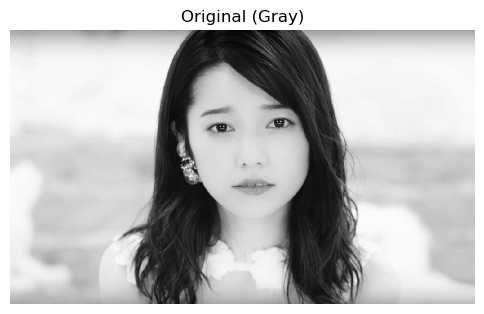

In [5]:

plt.imshow(original, cmap='gray')
plt.title('Original (Gray)')
plt.axis('off')


## Method 1: canny detector
Using canny detector to locate the contour of the face, upon which a rough face center could be computed

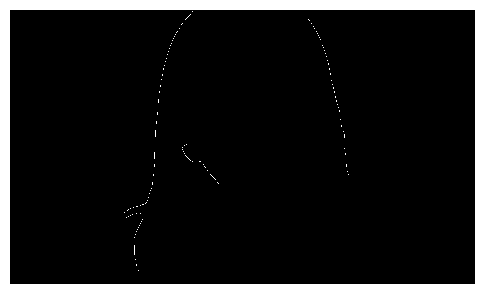

In [6]:
cannyIm = feature.canny(original,8)
plt.figure()
plt.axis('off')
plt.imshow(cannyIm, cmap=cm.gray)

In [7]:
find_center(cannyIm)

(664.2834279814145, 394.1905007743934)

## Method 2: Extension of sobel masks
Utilize three our designed extended sobel masks (inlcuding the original sobel mask) to detect egde, symetrical structure, diagonal structure.

In [8]:
soble_x=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
soble_y=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

soble_symmetric_x = np.array([[-1,-2,-1],[2,4,2],[-1,-2,-1]])
soble_symmetric_y = np.array([[-1,2,-1],[-2,4,-2],[-1,2,-1]])

soble_diagnoal_1 = np.array([[0,-1,-1],[1,0,-1],[1,1,0]])
soble_diagnoal_2 = np.array([[1,1,0],[1,0,-1],[0,-1,-1]])



In [9]:
gxIm = ndimage.correlate(original, soble_x, mode='nearest')
gyIm = ndimage.correlate(original, soble_y, mode='nearest')
gxImS = ndimage.correlate(original, soble_symmetric_x, mode='nearest')
gyImS = ndimage.correlate(original, soble_symmetric_y, mode='nearest')
g1ImD = ndimage.correlate(original, soble_diagnoal_1, mode='nearest')
g2ImD = ndimage.correlate(original, soble_diagnoal_2, mode='nearest')

In [10]:
import scipy.ndimage as ndimage

In [11]:
gIm = np.maximum(np.abs(gxIm),np.abs(gyIm))
gImS = np.maximum(np.abs(gxImS),np.abs(gyImS))
gImD = np.maximum(np.abs(g1ImD),np.abs(g2ImD))


In [12]:
n=0.01

T = gIm.reshape(-1)[np.argsort(gIm.reshape(-1))][-int(gIm.shape[0]*gIm.shape[1]*n)]
TS = gImS.reshape(-1)[np.argsort(gImS.reshape(-1))][-int(gImS.shape[0]*gImS.shape[1]*n)]
TD = gImD.reshape(-1)[np.argsort(gImD.reshape(-1))][-int(gImD.shape[0]*gImD.shape[1]*n)]


In [13]:
gIm.shape

(885, 1500)

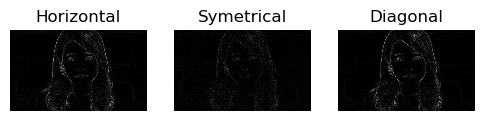

In [14]:
fig, ax = plt.subplots(ncols=3)

ax[0].set_title('Horizontal')
ax[0].axis('off')
ax[0].imshow(np.maximum(0,gIm), cmap=cm.gray)
# ax[0].imshow(gIm>T, cmap=cm.gray)

ax[1].set_title('Symetrical')
ax[1].axis('off')
ax[1].imshow(np.maximum(0,gImS), cmap=cm.gray)
# ax[1].imshow(gImS>TS, cmap=cm.gray)

ax[2].set_title('Diagonal')
ax[2].axis('off')
ax[2].imshow(np.maximum(0,gImD), cmap=cm.gray)
# ax[2].imshow(gImD>TD, cmap=cm.gray)

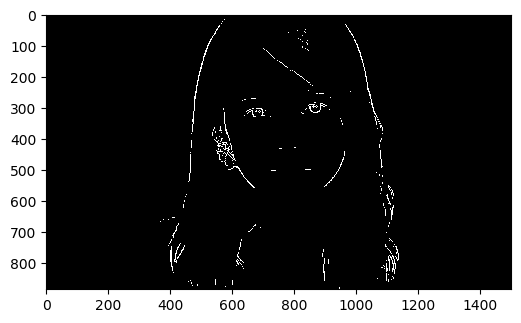

In [15]:
plt.imshow(gIm>T, cmap='gray')

In [16]:
temp=np.logical_and(gIm>T, np.logical_and(gImS>TS,gImD>TD))

### 2.1 after obtaining the resultant matrix, directly take the average

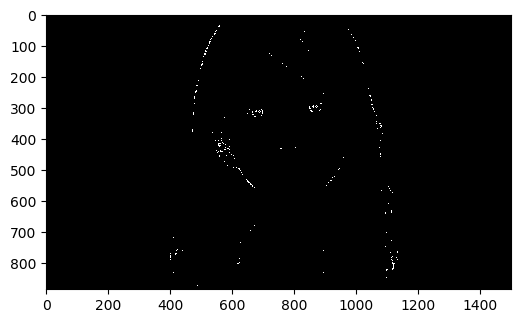

In [17]:
plt.imshow(temp, cmap='gray')

In [18]:
find_center(temp)

(738.7911262798635, 414.0747440273038)

### 2.2 after obtaining the resultant matrix, apply opening (dilution followed by errosion) and then take the average

In [19]:
b=ndimage.binary_opening(temp)

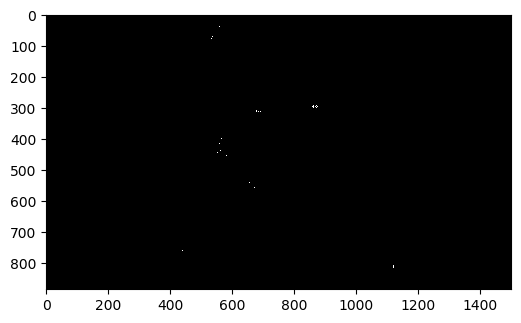

In [20]:
plt.imshow(b, cmap='gray')

In [21]:
find_center(b)

(740.9555555555555, 404.36296296296297)

### 2.3 after obtaining the resultant matrix, apply opening and finding the largest region (normally one of eyes). In this approach, the center will no longer be the center of the face contour but instead the location of the eye.

The regions, and their counts
(1, 5)
(2, 8)
(3, 5)
(4, 8)
(5, 31)
(6, 33)
(7, 24)
(8, 23)
(9, 5)
(10, 5)
(11, 5)
(12, 5)
(13, 5)
(14, 8)
(15, 12)
(16, 5)
(17, 5)
(18, 5)
(19, 5)
(20, 5)
(21, 5)
(22, 5)
(23, 5)
(24, 5)
(25, 5)
(26, 5)
(27, 5)
(28, 5)
(29, 23)


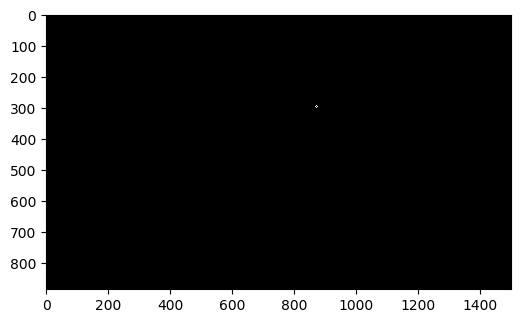

In [22]:
(L, num) = ndimage.label(b)
max_reg = (0, 0)
print("The regions, and their counts")
for i in range(1, num+1):
    temp = (L == i).astype('uint8')
    temp_count = np.count_nonzero(temp)
    print((i, temp_count))
    max_reg = (i, temp_count) if max_reg[1] < temp_count else max_reg

plt.imshow(L == max_reg[0], cmap='gray')

In [23]:
find_center(L == max_reg[0])

(872.2727272727273, 297.1818181818182)

### 2.4 A new "circular" (rotational symmetry) mask, designed for detecting both eyes. Then, the center will be the mid-point of two eyes.

In [24]:
soble_center = np.array([[-3,-1,0,-1,-3],[-1,0,3,0,-1],[0,3,8,3,0],[-1,0,3,0,-1],[-3,-1,0,-1,-3]])

In [25]:
gImC = ndimage.correlate(original, soble_center, mode='nearest')

In [26]:
TC_only = gImC.reshape(-1)[np.argsort(gImC.reshape(-1))][-int(gImC.shape[0]*gImC.shape[1]*(n**2))]

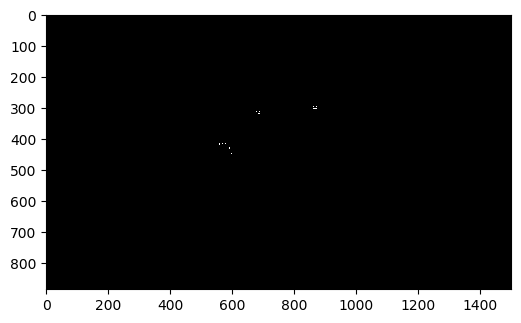

In [27]:
plt.imshow(gImC>TC_only, cmap='gray')

In [28]:
find_center(gImC>TC_only)

(681.3587786259542, 363.9618320610687)

In [29]:
TC = gImC.reshape(-1)[np.argsort(gImC.reshape(-1))][-int(gImC.shape[0]*gImC.shape[1]*(n*0.1))]

In [30]:
temp=np.logical_and(gImC>TC,np.logical_and(gIm>T, np.logical_and(gImS>TS,gImD>TD)))

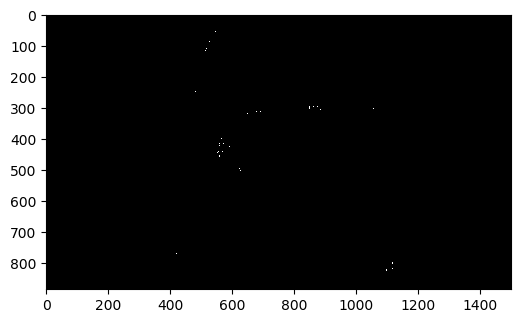

In [31]:
plt.imshow(temp, cmap='gray')

In [32]:
find_center(temp)

(710.6284289276808, 413.9700748129676)

In [33]:
b=ndimage.binary_opening(temp)

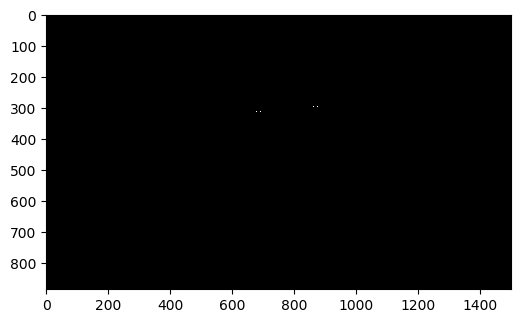

In [34]:
plt.imshow(b, cmap='gray')

In [35]:
find_center(b)

(800.8571428571429, 302.42857142857144)